In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from shutil import copyfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
copyfile('/content/drive/MyDrive/efficientnet_b0_baseline_model.h5', '/content/efficientnet_b0_baseline_model.h5')
copyfile('/content/drive/MyDrive/PCBData_convtd.zip', '/content/PCBData_convtd.zip')
!unzip PCBData_convtd.zip

## Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [ ]:
import os
num_skipped = 0
folders = []
for i in range(1, 7):
    folders.append('PCBData_convtd/test/'+ str(i))
for folder_name in folders:
    folder_path = folder_name
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


## Generate a Dataset

In [ ]:
image_size = (150, 150)
batch_size = 32

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "PCBData_convtd/test",
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=image_size,
)
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    "PCBData_convtd/test",
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=image_size,
)


Found 10013 files belonging to 6 classes.
Using 8011 files for training.
Found 10013 files belonging to 6 classes.
Using 2002 files for validation.


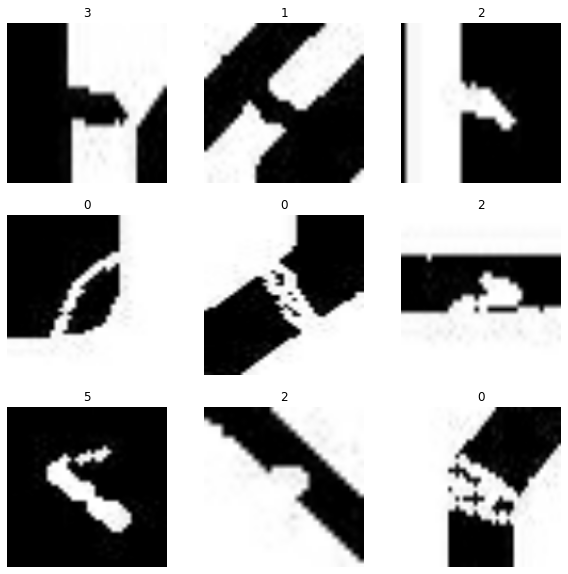

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Two options to preprocess the data

There are two ways you could be using the data_augmentation preprocessor:

Option 1: Make it part of the model, like this:
If you're training on GPU, this is the better option.

Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images
If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the first option.

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [ ]:
# One-hot / categorical encoding
NUM_CLASSES = 6
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# )
# ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
# ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
# ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
IMG_SIZE = 150

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)

base_model = EfficientNetB0(include_top=False, weights='imagenet', classes=NUM_CLASSES)(x)
 
# add a global spatial average pooling layer
x = base_model
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, predictions)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 150, 150, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 5,367,465
Trainable params: 5,325,442
Non-trainable params: 42,023
______________________________________________

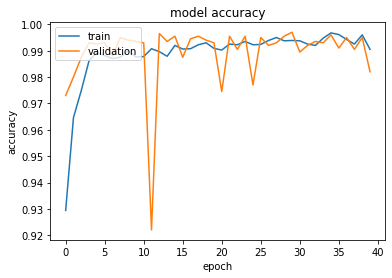

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)


In [ ]:
_, baseline_model_accuracy = model.evaluate(ds_test, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)


Baseline test accuracy: 0.982017993927002


In [ ]:
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

In [ ]:
model_baseline = tfmot.sparsity.keras.strip_pruning(model)
keras_file = 'efficientnet_b0_baseline_model.h5'
tf.keras.models.save_model(model_baseline, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved baseline model to: efficientnet_b0_baseline_model.h5


In [ ]:
!ls -l

total 43956
drwx------ 5 root root     4096 Jun 15 07:42 drive
-rw-r--r-- 1 root root 21864192 Jun 15 09:41 efficientnet_b0_baseline_model.h5
-rw-r--r-- 1 root root   493512 Jun 15 07:54 model.png
drwxr-xr-x 4 root root     4096 Jun 15 08:28 PCBData_convtd
-rw-r--r-- 1 root root 22635199 Jun 15 08:28 PCBData_convtd.zip
drwxr-xr-x 1 root root     4096 Jun  1 13:40 sample_data
